In [1]:
import json 
import numpy as np
import matplotlib.pyplot as plt
import glob 
from dataclasses import dataclass
import pandas as pd


In [2]:
@dataclass 
class ModelGeneration:
    model_path: str 
    question_num: int
    sample_num: int
    generation: str 
    embedding: list 


def load_generations(file_path):

    with open(file_path, 'r') as f:
        data = json.load(f)
        

    return ModelGeneration(
        model_path=file_path.split('/')[-2],
        question_num=data['task_id'],
        sample_num=data['sample_idx'],
        generation=data['output'],
        embedding=data['generated_embedding']
        # embedding=data['generated_embedding']
    )

dirs = glob.glob('../embeddings/*')

# ADD base
model_names = ['_'.join(k.split('/')[-1].split('_')[0:-3]) for k in dirs]
model_names = [k.split('/')[-1] for k in dirs]
generations = []

for model_name in model_names:
    model_path = f"/scratch/gpfs/vv7118/messi-thinking/embeddings/{model_name}"
    model_files = glob.glob(f"{model_path}/*.json")
    for file_path in model_files:
        try: 
            generations.append(load_generations(file_path))
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")



In [3]:
def calculate_cosine_similarities(df, model_name):
    """Calculate cosine similarities between all rows for a specific model."""
    # Filter for the specific model
    model_df = df[df['model_path'] == model_name].copy()
    
    embeddings = np.array([np.array(emb) for emb in model_df['embedding']])
    similarity_matrix = np.dot(embeddings, embeddings.T)
    sims = similarity_matrix.mean(axis=1)
    model_df['avg_question_similarity'] = sims
    return model_df

In [4]:
def calculate_same_question_similarities(df, model_name):
    """Calculate mean cosine similarities between generations of the same question."""
    model_df = df[df['model_path'] == model_name].copy()
    question_groups = model_df.groupby('question_num')
    
    results = []
    
    for question_num, group in question_groups:
        if len(group) <= 1:
            continue
        embeddings = np.array([np.array(emb) for emb in group['embedding']])
        
        norms = np.linalg.norm(embeddings, axis=1)
        
        normalized_embeddings = embeddings / norms[:, np.newaxis]
        
        similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
        
        np.fill_diagonal(similarity_matrix, 0)
        
        mean_similarity = similarity_matrix.sum() / (len(group) * (len(group) - 1))
        
        results.append({
            'question_num': question_num,
            'num_samples': len(group),
            'mean_similarity': mean_similarity
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df
    

In [51]:
df = df[df['generation'].str.contains('```')]

In [5]:
df = pd.DataFrame(generations)
df = df[df['question_num'] < 1000]
df = df[df['sample_num'] < 11]
# df = df[df['generation'].str.startswith('```')]

In [43]:
df['str_len'] = df['generation'].str.len()
df['str_len_bucket'] = pd.qcut(df['str_len'], q=10, labels=False)

In [19]:
dfs = []

for model in model_names: 
    try: 
        dfs.append(calculate_cosine_similarities(df, model))
    except:
        print(model)

5206a32e0bd3067aef1ce90f5528ade7d866253f_diff_MEDIUM_nosysprompt
gemme-3-4b-pt_diff_MEDIUM_nosysprompt
Llama-3.1-70B-Instruct_diff_MEDIUM_nosysprompt


In [20]:
pd.concat(dfs, axis=0).groupby(['model_path'])['avg_question_similarity'].mean()


model_path
Llama-3.1-8B-Instruct_diff_MEDIUM_nosysprompt    0.393570
Llama-3.1-8B_diff_MEDIUM_nosysprompt             0.368730
Llama-3.2-3B-Instruct_diff_MEDIUM_nosysprompt    0.459378
Llama-3.2-3B_diff_MEDIUM_nosysprompt             0.350447
gemma-3-12b-0.7-lerp_diff_MEDIUM_nosysprompt     0.618771
gemma-3-12b-0.9-lerp_diff_MEDIUM_nosysprompt     0.625269
gemma-3-12b-it_diff_MEDIUM_nosysprompt           0.622953
gemma-3-12b-pt_diff_MEDIUM_nosysprompt           0.399992
gemma-3-4b-0.7-lerp_diff_MEDIUM_nosysprompt      0.672972
gemma-3-4b-0.9-lerp_diff_MEDIUM_nosysprompt      0.681600
gemma-3-4b-it_diff_MEDIUM_nosysprompt            0.686878
gemma-3-4b-pt_diff_MEDIUM_nosysprompt            0.377591
ll31_8b_lerp_0.5_diff_MEDIUM_nosysprompt         0.543934
ll31_8b_lerp_0.7_diff_MEDIUM_nosysprompt         0.483679
ll31_8b_lerp_0.9_diff_MEDIUM_nosysprompt         0.560969
ll32_3b_lerp_0.7_diff_MEDIUM_nosysprompt         0.465338
ll32_3b_lerp_0.9_diff_MEDIUM_nosysprompt         0.504375
Nam

In [21]:
model_names = {
    # Gemma models
    # 'gemma-3-12b-pt_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (pretrained)',
    'gemma-3-12b-it_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (instruct)',
    'gemma-3-4b-it_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (instruct)',
    # 'gemma-3-4b-pt_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (pretrained)',
    'gemma-3-4b-0.7-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (alpha=0.7)',
    'gemma-3-4b-0.9-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (alpha=0.9)',
    'gemma-3-12b-0.9-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (alpha=0.9)',
    'gemma-3-12b-0.7-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (alpha=0.7)',
    
    # Llama models
    'Llama-3.1-8B_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (pretrained)',
    'Llama-3.1-8B-Instruct_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (instruct)',
    # 'Llama-3.2-3B_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (pretrained)',
    'Llama-3.2-3B-Instruct_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (instruct)',
    'll31_8b_lerp_0.7_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (alpha=0.7)',
    'll31_8b_lerp_0.9_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (alpha=0.9)',
    'll32_3b_lerp_0.7_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (alpha=0.7)',
    'll32_3b_lerp_0.9_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (alpha=0.9)',
}


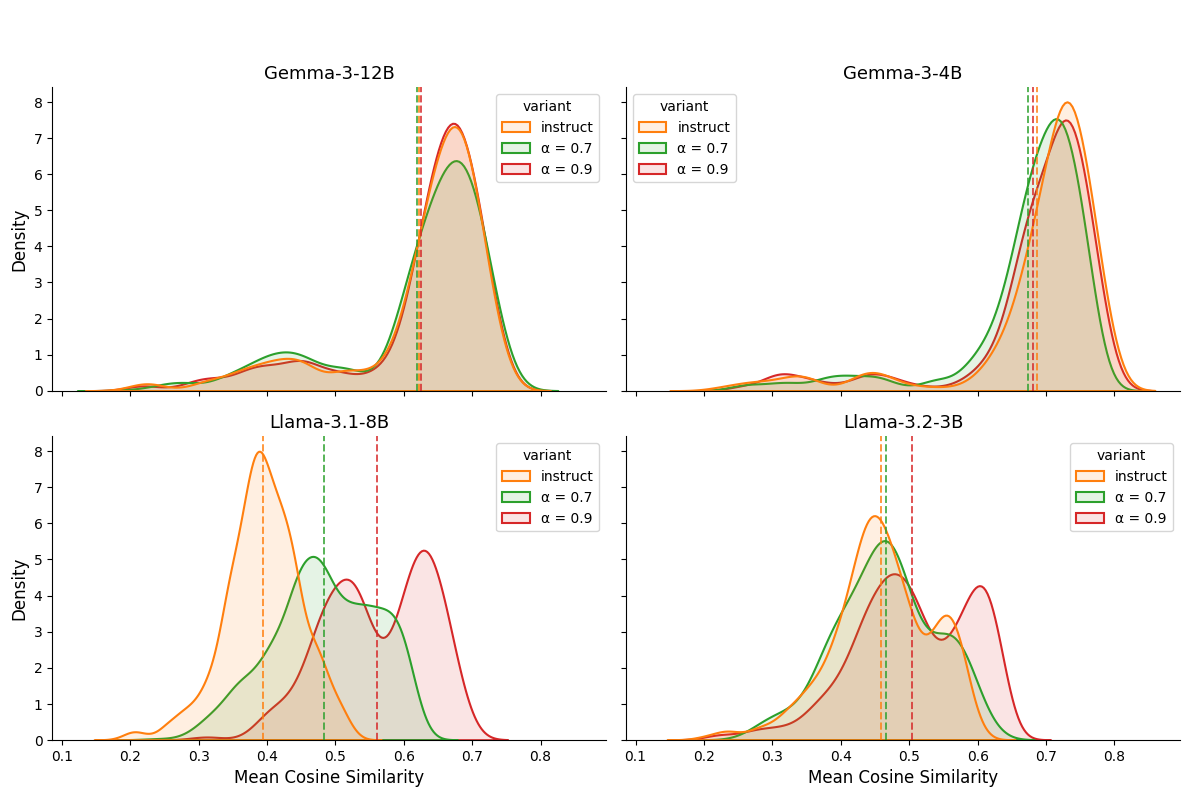

In [22]:
import seaborn as sns

# ── organise every model variant ------------------------------------------------
#  df_all must have *at least* the columns:
#      model_path   avg_question_similarity
#  If yours are named a bit differently, just tweak below two lines.
df_all = pd.concat(dfs, axis=0, ignore_index=True)   # already in the notebook
metric_col = "avg_question_similarity"               # rename if needed

subplot_specs = {
    "Gemma-3-12B": [
        # ("gemma-3-12b-pt_diff_MEDIUM_nosysprompt",        "pre-trained"),
        ("gemma-3-12b-it_diff_MEDIUM_nosysprompt",        "instruct"),
        ("gemma-3-12b-0.7-lerp_diff_MEDIUM_nosysprompt",  "α = 0.7"),
        ("gemma-3-12b-0.9-lerp_diff_MEDIUM_nosysprompt",  "α = 0.9"),
    ],
    "Gemma-3-4B": [
        # ("gemma-3-4b-pt_diff_MEDIUM_nosysprompt",         "pre-trained"),
        ("gemma-3-4b-it_diff_MEDIUM_nosysprompt",         "instruct"),
        ("gemma-3-4b-0.7-lerp_diff_MEDIUM_nosysprompt",   "α = 0.7"),
        ("gemma-3-4b-0.9-lerp_diff_MEDIUM_nosysprompt",   "α = 0.9"),
    ],
    "Llama-3.1-8B": [
        # ("Llama-3.1-8B_diff_MEDIUM_nosysprompt",          "pre-trained"),
        ("Llama-3.1-8B-Instruct_diff_MEDIUM_nosysprompt", "instruct"),
        ("ll31_8b_lerp_0.7_diff_MEDIUM_nosysprompt",      "α = 0.7"),
        ("ll31_8b_lerp_0.9_diff_MEDIUM_nosysprompt",      "α = 0.9"),
    ],
    "Llama-3.2-3B": [
        # ("Llama-3.2-3B_diff_MEDIUM_nosysprompt",          "pre-trained"),
        ("Llama-3.2-3B-Instruct_diff_MEDIUM_nosysprompt", "instruct"),
        ("ll32_3b_lerp_0.7_diff_MEDIUM_nosysprompt",      "α = 0.7"),
        ("ll32_3b_lerp_0.9_diff_MEDIUM_nosysprompt",      "α = 0.9"),
    ],
}

# a consistent colour per variant across sub-plots
variant_palette = {
    "pre-trained": sns.color_palette("tab10")[0],
    "instruct":    sns.color_palette("tab10")[1],
    "α = 0.7":     sns.color_palette("tab10")[2],
    "α = 0.9":     sns.color_palette("tab10")[3],
}

# ── plotting --------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (model_family, variant_list) in zip(axes, subplot_specs.items()):
    # collect rows for the current family into one tidy df
    tidied = []
    for tag, variant_label in variant_list:
        rows = df_all.loc[df_all.model_path == tag, metric_col]
        if rows.empty:
            continue                            # skip missing runs
        tmp_df = pd.DataFrame({
            "similarity": rows,
            "variant": variant_label,
        })
        tidied.append(tmp_df)
    if not tidied:
        ax.set_visible(False)                   # nothing to show
        continue
    plot_df = pd.concat(tidied, ignore_index=True)
    
    # KDE curves with filled + line
    # sns.kdeplot(
    #     data=plot_df,
    #     x="similarity",
    #     hue="variant",
    #     ax=ax,
    #     palette=variant_palette,
    #     fill=True,  alpha=.12,
    #     common_norm=False
    # )
    # sns.kdeplot(
    #     data=plot_df,
    #     x="similarity",
    #     hue="variant",
    #     ax=ax,
    #     palette=variant_palette,
    #     fill=False, alpha=1,
    #     linewidth=1.5,
    #     legend=False
    # )
    sns.kdeplot(
        data=plot_df,
        x="similarity",
        hue="variant",
        ax=ax,
        palette=variant_palette,
        fill=True,     # filled plus one outline
        alpha=.12,
        linewidth=1.5,  # outline thickness
        common_norm=False
    )
    
    # vertical means
    for variant_label, grp in plot_df.groupby("variant"):
        mu = grp["similarity"].mean()
        ax.axvline(mu,
                   color=variant_palette[variant_label],
                   ls="--", lw=1.4, alpha=.8)
    
    ax.set_title(model_family, fontsize=13, pad=6)
    ax.set_xlabel("")
    ax.set_ylabel("")

# cosmetic tweaks
for ax in axes:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=10)

axes[2].set_xlabel("Mean Cosine Similarity", fontsize=12)    # bottom left
axes[3].set_xlabel("Mean Cosine Similarity", fontsize=12)    # bottom right
axes[0].set_ylabel("Density", fontsize=12)                   # top left
axes[2].set_ylabel("Density", fontsize=12)                   # bottom left

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=11, frameon=False)

plt.tight_layout(rect=[0,0,1,0.94])
plt.savefig("avg_question_similarity_2x2.pdf", dpi=300, bbox_inches="tight")
plt.show()

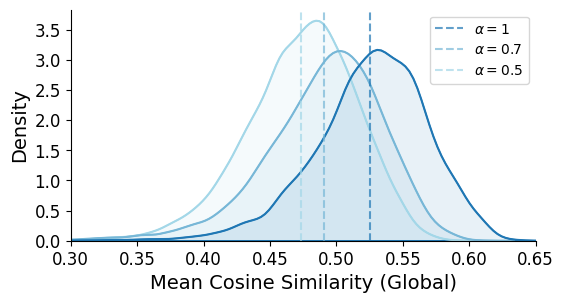

In [23]:
dfs = []

for model in model_names: 
    try: 
        dfs.append(calculate_same_question_similarities(df, model))
    except:
        print(model)

In [29]:
print(model_names)

{'gemma-3-12b-it_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (instruct)', 'gemma-3-4b-it_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (instruct)', 'gemma-3-4b-0.7-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (alpha=0.7)', 'gemma-3-4b-0.9-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-4B (alpha=0.9)', 'gemma-3-12b-0.9-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (alpha=0.9)', 'gemma-3-12b-0.7-lerp_diff_MEDIUM_nosysprompt': 'Gemma-3-12B (alpha=0.7)', 'Llama-3.1-8B_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (pretrained)', 'Llama-3.1-8B-Instruct_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (instruct)', 'Llama-3.2-3B-Instruct_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (instruct)', 'll31_8b_lerp_0.7_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (alpha=0.7)', 'll31_8b_lerp_0.9_diff_MEDIUM_nosysprompt': 'Llama-3.1-8B (alpha=0.9)', 'll32_3b_lerp_0.7_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (alpha=0.7)', 'll32_3b_lerp_0.9_diff_MEDIUM_nosysprompt': 'Llama-3.2-3B (alpha=0.9)'}


In [31]:
dfs[-1]['mean_similarity'].mean()

0.8163624226604708

In [24]:
dfs = [df for df in dfs if len(df) > 0]

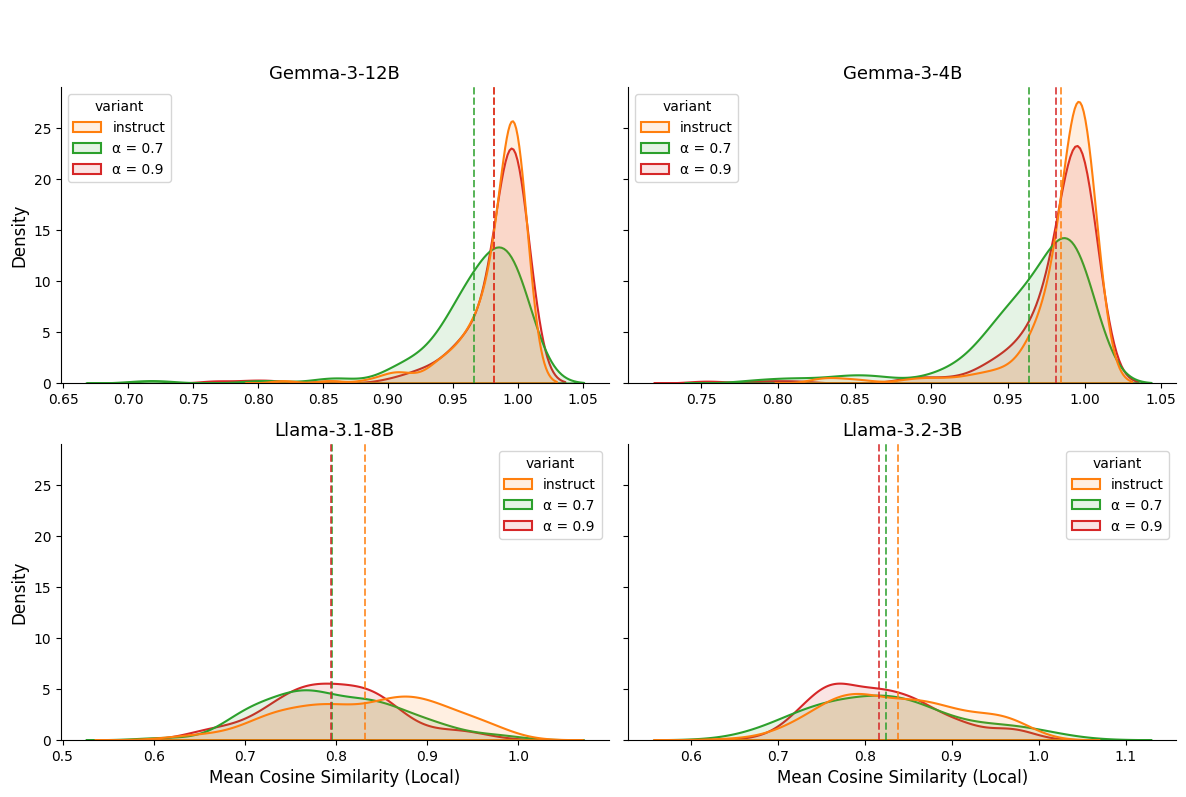

In [26]:
# ── collect SAME-QUESTION (local) similarities for every model variant ─────────
dfs_local = []
for m in model_names:                  # same list you used earlier
    try:
        tmp = calculate_same_question_similarities(df, m)
        if not tmp.empty:
            tmp["model_path"] = m      # add model id so we can filter later
            dfs_local.append(tmp)
    except Exception:
        pass                           # skip models that don’t have data

df_local_all = pd.concat(dfs_local, ignore_index=True)
metric_col_local = "mean_similarity"   # column to plot

# ── plotting: identical to the global 2×2 block, just use df_local_all ─────────
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()

for ax, (model_family, variant_list) in zip(axes, subplot_specs.items()):
    # gather rows for current family
    tidied = []
    for tag, variant_label in variant_list:
        rows = df_local_all.loc[df_local_all.model_path == tag, metric_col_local]
        if rows.empty:
            continue
        tidied.append(pd.DataFrame({"similarity": rows, "variant": variant_label}))
    if not tidied:
        ax.set_visible(False)
        continue
    plot_df = pd.concat(tidied, ignore_index=True)
    
    sns.kdeplot(data=plot_df, x="similarity", hue="variant", ax=ax,
                palette=variant_palette, fill=True, alpha=.12,
                linewidth=1.5, common_norm=False)
    
    # vertical mean lines per variant
    for variant_label, grp in plot_df.groupby("variant"):
        mu = grp["similarity"].mean()
        ax.axvline(mu, color=variant_palette[variant_label], ls="--",
                   lw=1.4, alpha=.8)
    
    ax.set_title(model_family, fontsize=13, pad=6)
    ax.set_xlabel("");  ax.set_ylabel("")

# cosmetic tweaks (same as global)
for ax in axes:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=10)

axes[2].set_xlabel("Mean Cosine Similarity (Local)", fontsize=12)
axes[3].set_xlabel("Mean Cosine Similarity (Local)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[2].set_ylabel("Density", fontsize=12)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=11, frameon=False)

plt.tight_layout(rect=[0,0,1,0.94])
plt.savefig("avg_same_question_similarity_2x2.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
import seaborn as sns
plot_data = pd.concat([
    pd.DataFrame({
        'similarity': m['mean_similarity'],
        'model': model
    }) for m, model in zip(dfs, model)
])

# Create the plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=True, alpha=0.1)
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=False, alpha=1)# plt.title('Same-Question Similarities by Model', fontsize=15)
plt.xlabel('Mean Cosine Similarity (Local)', fontsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.ylabel('Density', fontsize=14)
model_means = {
    'llama_8b_single': m1['mean_similarity'].mean(),
    'llama_8b_slerp_0.90': m3['mean_similarity'].mean(),
    'llama_8b_slerp_0.70': m2['mean_similarity'].mean(),
    'llama_8b_slerp_0.50': m4['mean_similarity'].mean(),
    'llama-3.1-8b': m5['mean_similarity'].mean(),
    # 'messy_reasoning_not_blind': m5['mean_similarity'].mean(),
}
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(0.7, 1.0)  # Add this line to limit x-axis


for model, mean in model_means.items():
    plt.axvline(mean, color=model_colors[model], linestyle='--', alpha=.7, linewidth=1.5,
               label=f'{name_mapping[model]}')
plt.legend(fontsize=10)
plt.savefig('avg_same_question_similarity_with_base.pdf', dpi=300, bbox_inches='tight')

plt.show()



NameError: name 'model_colors' is not defined

<Figure size 600x400 with 0 Axes>

In [ ]:
import seaborn as sns
model_colors = {
    'llama_8b_single': '#1f77b4',  # blue
    'llama_8b_slerp_0.90': '#2ca02c',  # green
    'llama_8b_slerp_0.70': '#ff7f0e',  # orange
    'llama_8b_slerp_0.50': '#9467bd',  # purple
    # 'messy_reasoning_not_blind': '#d62728'  # red
}
model_colors = {
    'llama_8b_single': '#1f77b4',        # darkest blue
    # 'llama_8b_slerp_0.90': '#4b97c5',    # slightly lighter blue
    'llama_8b_slerp_0.70': '#77b7d7',    # lighter blue
    'llama_8b_slerp_0.50': '#a3d7e8',    # lightest blue
    # "llama-3.1-8b": "#2ca02c",
    # 'messy_reasoning_not_blind': '#d62728'          # red
}
# model_colors = {
#     'llama_8b_single': '#1f77b4',        # blue
#     'llama_8b_slerp_0.90': '#d62728',    # red
#     'llama_8b_slerp_0.70': '#9467bd',    # purple
#     'llama_8b_slerp_0.50': '#1f77b4',    # blue
#     'messy_reasoning': '#2ca02c'          # green
# }

plot_data = pd.concat([
    pd.DataFrame({
        'similarity': df1['avg_question_similarity'],
        'model': 'llama_8b_single'
    }),
    pd.DataFrame({
        'similarity': df2['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.70'
    }),
    # pd.DataFrame({
    #     'similarity': df3['avg_question_similarity'],
    #     'model': 'llama_8b_slerp_0.90'
    # }),
    pd.DataFrame({
        'similarity': df4['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.50'
    }),
    # pd.DataFrame({
    #     'similarity': df5['avg_question_similarity'],
    #     'model': 'llama-3.1-8b'
    # }),
    # pd.DataFrame({
    #     'similarity': df5['avg_question_similarity'],
    #     'model': 'messy_reasoning_not_blind'
    # }),
])

# Create the plot
plt.figure(figsize=(6, 3))
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=True, alpha=0.1, palette=model_colors)
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=False, alpha=1, palette=model_colors)#
# plt.title('Similarities by Model', fontsize=15)
plt.xlabel('Mean Cosine Similarity (Global)', fontsize=14)
plt.ylabel('Density', fontsize=14)

for model, color in model_colors.items():
    if model == 'llama_8b_single':
        mean = df1['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.70':
        mean = df2['avg_question_similarity'].mean()
    # elif model == 'llama_8b_slerp_0.90':
    #     mean = df3['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.50':
        mean = df4['avg_question_similarity'].mean()
    # elif model == 'messy_reasoning_not_blind':
    #     mean = df5['avg_question_similarity'].mean()
    # elif model == 'llama-3.1-8b':
    #     mean = df5['avg_question_similarity'].mean()
    plt.axvline(mean, color=color, linestyle='--', alpha=.7, linewidth=1.5,
               label=f'{name_mapping[model]}')
plt.xlim(0.3, 0.65)  # Add this line to limit x-axis

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.legend(fontsize=10)
plt.savefig('avg_question_similarity.pdf', dpi=300, bbox_inches='tight')
plt.show()